In [ ]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Subset

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import glob

####
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


<ipython-input-1-f53b51a70856>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

/bin/bash: line 1: nvidia-smi: command not found


False

In [ ]:
DEVICE = torch.device('cuda')

lets transfer data from kaggle to google colab
with help of this notebook:
https://www.kaggle.com/discussions/general/74235



In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maksimrazantsau","key":"e24e382432a1c653ad7e8b3118ea35c7"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c journey-springfield

 99% 514M/521M [00:08<00:00, 78.4MB/s]
100% 521M/521M [00:08<00:00, 60.7MB/s]


In [ ]:
! unzip journey-springfield.zip

In [ ]:
! rm /content/journey-springfield.zip /content/characters_illustration.png

I want to check the sizes of our images

In [ ]:
data_dir = '/content/train/simpsons_dataset'

data_transform = (
        transforms.ToTensor()
)
dataset_size = datasets.ImageFolder(data_dir, data_transform)
dataloader_size = torch.utils.data.DataLoader(dataset_size, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
i = 0
for batch in dataloader_size:
  print(batch[0].size())
  i += 1
  if i == 50:
    break


lets create dataset for training and validating with transforamtions

In [ ]:
# def train_val_split(dataset, split=0.1):
#     train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size = split)
#     datasets = {}
#     datasets['train'] = Subset(train_idx, dataset)
#     datasets['val'] = Subset(val_idx, dataset)
#     return datasets


 This functions seemed to be useless, because I dont know how to apply
 transformations to train dataset after creating train/val datasets, maybe I need to create my own dataset class


In [ ]:
# class MyData(Dataset):
#     def __init__(self, data_directory):
#         self.imgs_path = data_directory
#         file_list = glob.glob(self.imgs_path + "*")
#         self.data = []
#         for class_path in file_list:
#             class_name = class_path.split("/")[-1]
#             for img_path in glob.glob(class_path + "/*.jpg"):
#                 self.data.append([img_path, class_name])
#         #self.class_map = {"dogs" : 0, "cats": 1}
#         self.img_dim = (416, 416)
#         self.set_stage(0) # initial stage
#         self.hflip = transforms.RandomHorizontalFlip(p=0.5)
#         self.vflip = transforms.RandomVerticalFlip(p=0.5)
#         self.rotation = transforms.RandomRotation(degrees=15)
#         self.resize = transforms.Resize(self.img_dim)

#     def __getitem__(self, index):
#         img_path, class_name = self.data[idx]
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, self.img_dim)

#         # Just apply your transformations here
#         if self.stage == 0:
#           img = self.crop(img)
#           img = self.hflip(img)
#           img = self.vflip(img)
#           img = self.rotation(img)

#         # img_tensor = torch.from_numpy(img)
#         # img_tensor = img_tensor.permute(2, 0, 1)
#         # class_id = torch.tensor([class_id])
#         return img, class_id

#     def set_stage(self, stage):
#         self.stage = stage

#     def __len__(self):
#         return len(self.data)


# dataset = MyData(data_dir)
# len(dataset)
# loader = DataLoader(dataset,
#                     batch_size=2,
#                     num_workers=2,
#                     shuffle=True)

# for batch_idx, data in enumerate(loader):
#     print('Batch idx {}, data shape {}'.format(
#         batch_idx, data.shape))

# loader.dataset.set_stage(1)

# for batch_idx, data in enumerate(loader):
#     print('Batch idx {}, data shape {}'.format(
#         batch_idx, data.shape))

0

15699
5234


(None, None)

In [ ]:
# from collections import Counter
# lst_train = []
# lst_val = []

# for file_train, file_val in zip(train_files, val_files):
#     lst_train.append(str(file_train.parent).split('/')[-1])
#     lst_val.append(str(file_val.parent).split('/')[-1])
# print(len(lst_train)), print(len(lst_val))
# Counter(lst_train).most_common(), Counter(lst_val).most_common()

In [ ]:
class SimpsonsData(Dataset):
    def __init__(self, files, mode):
        super().__init__()

        self.files = sorted(files)
        self.mode = mode
        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.len_

    def __getitem__(self, idx):
        x = self.files[idx]
        img = Image.open(x)
        img.load()
        img = img.resize((224, 224))
        x = np.array(img)
        #x = np.array(x / 255, dtype = 'float32')

        transform_test_val = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        transform_train = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if self.mode == 'test':
            return transform_test_val(x)

        elif self.mode == 'train':
            x = transform_train(x)
        else:
            x = transform_test_val(x)

        label = self.labels[idx]
        label_le = self.label_encoder.transform([label])
        y = label_le.item()
        return x, y


In [ ]:
TRAIN_DIR = Path('/content/train/simpsons_dataset')
TEST_DIR = Path('/content/testset/testset')

files_train_val = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split
files_labels = [file_path.parent.name for file_path in files_train_val]
train_files, val_files = train_test_split(files_train_val, test_size=0.25, stratify=files_labels)
print(len(train_files)), print(len(val_files))

15699
5234


(None, None)

In [ ]:
val_dataset = SimpsonsData(val_files, mode='val')
train_dataset = SimpsonsData(train_files, mode='train')

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, num_workers=2, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, num_workers=2, shuffle=True)

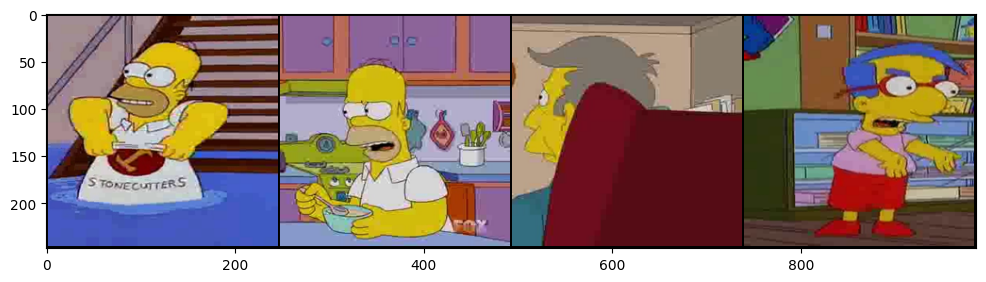

In [ ]:
def visualize(inp, title=None, batch_size=4):
  fig = plt.figure(figsize=(12, 8))


  inp = inp.numpy().transpose(1, 2, 0)
  inp = (inp * 255.0).astype('uint8')
  plt.imshow(inp)
  if title:
    plt.title(title)


outp, classes = next(iter(val_dataloader))
outp = torchvision.utils.make_grid(outp)

visualize(outp)

lets define train model function


how can I train and validate model on F1 score???

In [ ]:
# data_transform = (
#     transforms.Compose([
#         transforms.Resize(size=(400, 400)),
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.RandomRotation(degrees=15),
#         transforms.ToTensor()
#     ])
# )

# dataset = datasets.ImageFolder(data_dir, data_transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
# class_names = dataset.classes

In [ ]:
# def train_model_without_val(model, criterion, optimizer, scheduler, num_epochs=25):
#     start = time.time()
#     acc_

SyntaxError: ignored

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()
    best_model_params = model.state_dict()
    best_acc = 0.0

    losses = {'train' : [], 'val' : []}
    pbar = trange(num_epochs, desc='Epoch:')

    for epoch in pbar:

        for phase in ['train', 'val']:

            if phase == 'train':
              scheduler.step()
              model.train()
            else:
              model.eval()

            runnig_loss = 0.0
            running_corrects = 0

            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                inputs, labels = data

                if use_gpu:
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                else:
                  inputs, labels = inputs, labels

                if phase == 'train':
                  optimizer.zero_grad()

                if phase == 'val':
                  with torch.no_grad():
                    outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                runnig_loss += loss.item()
                running_corrects = torch.sum(preds==labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            loss[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))
            if epoch == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_params = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses
